Train an evidential regression model following the setup from https://arxiv.org/abs/1910.02600.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from probly.losses import EvidentialNIGNLLLoss, EvidentialRegressionRegularization
from probly.representation.regression import Evidential

### Generate synthetic data

In [2]:
def f(x: np.ndarray) -> np.ndarray:
    """Cubic function to generate synthetic data.

    Args:
        x: numpy.ndarray, input data
    Returns:
        y: numpy.ndarray, output data
    """
    eps = np.random.normal(0, 3, x.shape)
    return x**3 + eps


X_train = np.random.uniform(-4, 4, 500)
X_test = np.random.uniform(-6, 6, 250)
y_train = f(X_train)
y_test = f(X_test)
X_train = torch.from_numpy(X_train).float().view(-1, 1)
X_test = torch.from_numpy(X_test).float().view(-1, 1)
y_train = torch.from_numpy(y_train).float().view(-1, 1)
y_test = torch.from_numpy(y_test).float().view(-1, 1)
train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

### Define a neural network

In [3]:
class Net(nn.Module):
    """Simple Neural Network class.

    Attributes:
        fc1: nn.Module, first fully connected layer
        fc2: nn.Module, second fully connected layer
        fc3: nn.Module, third fully connected layer
        fc4: nn.Module, fourth fully connected layer
        act: nn.Module, activation function
    """

    def __init__(self) -> None:
        """Initializes an instance of the Net class."""
        super().__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 1)
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the neural network.

        Args:
            x: torch.Tensor, input data
        Returns:
            torch.Tensor, output data
        """
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()

### Transform it into an evidential regression model

In [4]:
model = Evidential(net)

### Train the network with the evidential loss and regularization

In [5]:
optimizer = optim.Adam(model.parameters(), 5e-3)
criterion = EvidentialNIGNLLLoss()
regularization = EvidentialRegressionRegularization()
lmbda = 0.01
for _ in tqdm(range(500)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets) + lmbda * regularization(outputs, targets)
        loss.backward()
        optimizer.step()

# compute MSE on test set
squared_error = 0
total = 0
model.eval()
for inputs, targets in test_loader:
    outputs = model(inputs)
    squared_error += torch.sum((outputs["gamma"] - targets) ** 2)
    total += targets.size(0)
print(f"MSE: {squared_error / total}")

100%|██████████| 500/500 [00:02<00:00, 222.96it/s]

MSE: 487.96392822265625


### Plot the predictions and the targets

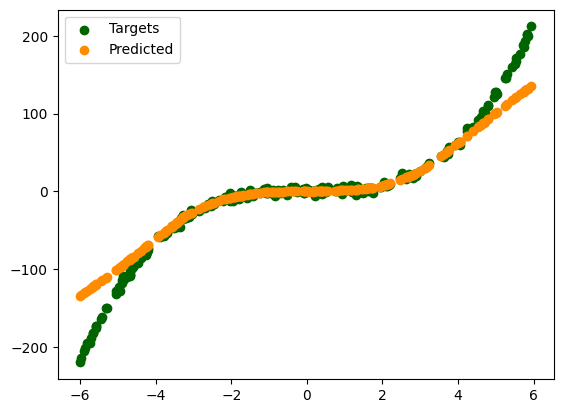

In [6]:
plt.scatter(X_test, y_test, label="Targets", c="darkgreen")
preds = model(X_test)["gamma"].detach().numpy()
plt.scatter(X_test, preds, label="Predicted", c="darkorange")
plt.legend()
plt.show()